In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
import torch.nn as nn
import math

from torch.utils.data import DataLoader

import seaborn as sns

In [2]:
# potential V, one-dimensional
def V(x):
    y1 = x**8
    y2 = 0.8 * np.exp(-80 * x**2)
    y3 = 0.55 * np.exp(-80 * (x-0.5)**2)
    y4 = 0.3 * np.exp(-80 * (x+0.5)**2)

    y = 2 * (y1 + y2 + y3 + y4)

    return y

# gradient of V
def gradV(x):
    y1 = 8 * x**7 
    y2 = - 0.8 * 160 * x * np.exp(-80 * x**2)
    y3 = - 0.55 * 160 * (x - 0.5) * np.exp(-80 * (x-0.5)**2) * 1.0
    y4 = - 0.3 * 160 * (x + 0.5) * np.exp(-80 * (x+0.5)**2) * 1.0

    y = 2 * (y1 + y2 + y3 + y4)

    return y

In [3]:
# coefficient in SDE
beta = 2.0
# step-size 
dt = 0.005
# number of sampling steps 
N = 10000
# range of the domain 
xmin, xmax = -1.0, 1.0

In [4]:
# sample the SDE using Euler-Maruyama scheme
def sample(beta=1.0, dt=0.001, N=10000, seed=42):
    rng = np.random.default_rng(seed=seed)
    X = 0.0
    traj = []
    tlist = []
    for i in range(N):
        traj.append(X)
        tlist.append(dt*i)        
        b = rng.normal()
        X = X - gradV(X) * dt + np.sqrt(2 * dt/beta) * b

    return np.array(tlist), np.array(traj)  

In [5]:
tvec, traj = sample(beta, dt=dt, N=N)

print ('Trajectory has %d states.\n' % traj.shape[0])

Trajectory has 10000 states.



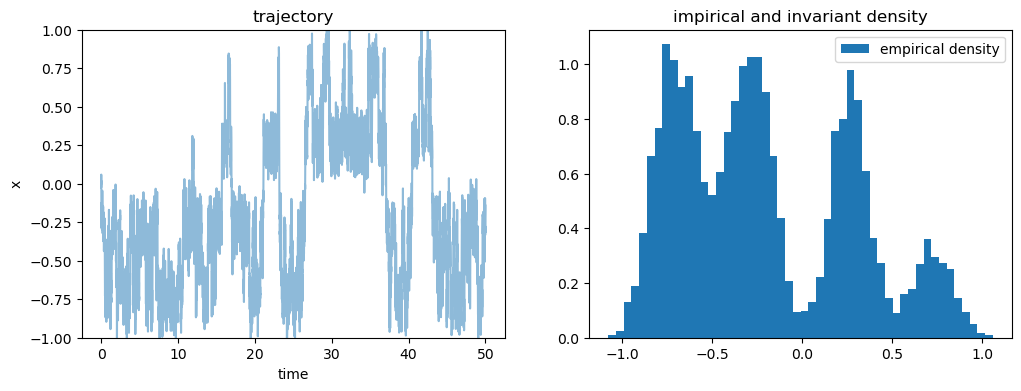

In [6]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

# plot trajectory vs time
ax.plot(tvec, traj, alpha=0.5)
ax.set_ylim([xmin, xmax])
ax.set_xlabel(r'time')
ax.set_ylabel(r'x')
ax.set_title('trajectory')

ax1 = fig.add_subplot(1, 2, 2)

# plot empirical density of the trajectory data
ax1.hist(traj, 50, density=True, label='empirical density')

ax1.set_title('impirical and invariant density')
ax1.legend()

In [62]:
class VESDE: 
    def __init__(self, sigma_min, sigma_max, dim=1, T=1):

        self.T = T
        self.dim = dim
        
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
    
    def drift(self, X, t):
        return torch.zeros_like(X)
    
    def diffusion(self, t):

        sigma = self.sigma_min * (self.sigma_max/self.sigma_min) ** (t/self.T) 

        ret = sigma  * torch.sqrt(1.0 / self.T \
                                  * torch.tensor(2 * (math.log(self.sigma_max) - math.log(self.sigma_min))))
        
        return ret

    def marginal_prob(self, X, t):
        mean = X
        std = self.sigma_min * (self.sigma_max/self.sigma_min) ** (t/self.T) 
        return mean, std 

    def prior(self, M):
        return torch.randn(M).reshape(-1, self.dim) * self.sigma_max
    
    # sample the SDE using Euler-Maruyama scheme
    def forward_sampling(self, X0, N=100):
        
        X = torch.tensor(X0).reshape(-1, self.dim)
        traj = [X]
        delta_t = self.T / N

        for i in range(N):

            b = torch.randn_like(X)

            t = i * delta_t * torch.ones(X.shape)
            
            drift = self.drift(X, t)

            diffusion_coeff = self.diffusion(t)

            X = X + drift * delta_t + diffusion_coeff * math.sqrt(delta_t) * b

            traj.append(X)

        return torch.stack(traj)

    # sample the SDE using Euler-Maruyama scheme
    def backward_sampling(self, X0, model, N=100): 
        
        if torch.is_tensor(X0) is False:
            X = torch.tensor(X0).reshape(-1, self.dim)
        else :           
            X = X0.reshape(-1, self.dim)
        traj = [X]
        delta_t = self.T / N

        for i in range(N):
            
            b = torch.randn_like(X)

            t = self.T - i * delta_t * torch.ones_like(X)
            score = model(X, t)
            
            drift = self.drift(X, t)
            diffusion_coeff = self.diffusion(t)

            X = X + (-1.0 * drift + diffusion_coeff**2 * score) * delta_t + math.sqrt(delta_t) * diffusion_coeff * b

            traj.append(X)

        return torch.stack(traj) 
    


In [63]:
T = 1

sigma_min = 0.03
sigma_max = 2

sde = VESDE(sigma_min, sigma_max, dim=1, T=T)

In [20]:
XT = sde.forward_sampling(traj, N=1000).detach().numpy()
print (XT.shape)

(1001, 10000, 1)


(-3.0, 3.0)

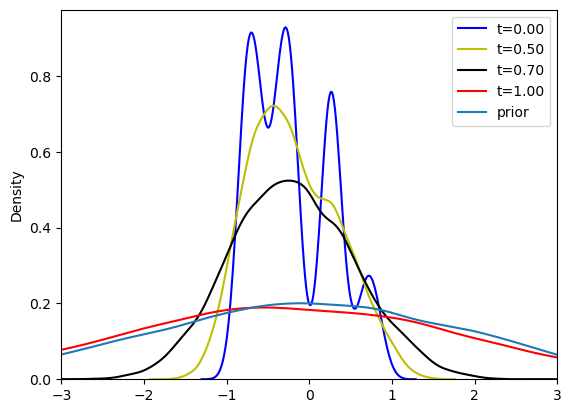

In [21]:
fig,ax = plt.subplots(1,1)

index_list = [0, 500, 700, 1000]
color_list = ['b', 'y', 'k', 'r', 'gray']
i=0
for idx in index_list:
    t = idx * T / 1000
    sns.kdeplot(XT[idx,:, 0], ax=ax, label='t=%.2f' % t, c=color_list[i])
    i += 1
    
X = sde.prior(20000)
sns.kdeplot(X, ax=ax, label='prior')
    
plt.legend()
ax.set_xlim(-3, 3)

In [27]:
class MyScore(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50), 
            nn.Tanh(),                      
            nn.Linear(50, 50),             
            nn.Tanh(),            
            nn.Linear(50, 1), 
       )
        
    # define how the output of model is computed given input x
    def forward(self, x, t):
        
        state = torch.cat((x, t), dim=1)

        output = self.net(state)
        
        return output
    
model = MyScore()    

epoch=0
   loss=-0.0080
epoch=100
   loss=-0.1575
epoch=200
   loss=-0.1905
epoch=300
   loss=-0.1772
epoch=400
   loss=-0.1836
epoch=500
   loss=-0.1813
epoch=600
   loss=-0.1749
epoch=700
   loss=-0.1921
epoch=800
   loss=-0.1909
epoch=900
   loss=-0.1972
epoch=1000
   loss=-0.1972
epoch=1100
   loss=-0.1750
epoch=1200
   loss=-0.2058
epoch=1300
   loss=-0.1949
epoch=1400
   loss=-0.1807
epoch=1500
   loss=-0.1735
epoch=1600
   loss=-0.1882
epoch=1700
   loss=-0.2045
epoch=1800
   loss=-0.1922
epoch=1900
   loss=-0.1902
epoch=2000
   loss=-0.1782
epoch=2100
   loss=-0.1950
epoch=2200
   loss=-0.1871
epoch=2300
   loss=-0.1891
epoch=2400
   loss=-0.2034
epoch=2500
   loss=-0.1963
epoch=2600
   loss=-0.1680
epoch=2700
   loss=-0.1829
epoch=2800
   loss=-0.1726
epoch=2900
   loss=-0.2092
epoch=3000
   loss=-0.1911
epoch=3100
   loss=-0.1908
epoch=3200
   loss=-0.1784
epoch=3300
   loss=-0.1727
epoch=3400
   loss=-0.1919
epoch=3500
   loss=-0.1797
epoch=3600
   loss=-0.1825
epoch=3700
  

Text(0.5, 1.0, 'loss vs epoch')

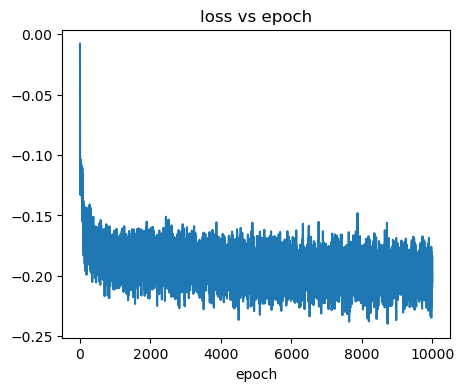

In [28]:
# batch-size
batch_size = 2000

# total training epochs
total_epochs = 5000

# represent the function g using a neural network
 
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

traj_data = torch.tensor(traj, dtype=torch.float32).reshape(-1,1)

data_loader = DataLoader(traj_data, batch_size=batch_size, shuffle=True, drop_last=True)

loss_list = []

for epoch in range(total_epochs):   # for each epoch
    
    for idx, data in enumerate(data_loader):  # loop over all mini-batches 

        t = torch.rand(data.shape[0]).reshape(-1, 1) * T 
        
        mean, std_t = sde.marginal_prob(data, t)        
        
        z = torch.randn_like(data)       
       
        xt = data + std_t * z
        
        score = model(xt,t) 

        loss = torch.mean((0.5*score**2 + score * z / std_t)*std_t**2)
                
        optimizer.zero_grad()
        # gradient step
        loss.backward()
        # update weights
        optimizer.step()
        
        if idx == 0:
            # record the loss    
            loss_list.append(loss.item())  
            if epoch % 100 == 0:
                print ('epoch=%d\n   loss=%.4f' % (epoch, loss.item()))   
                
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.plot(loss_list)
ax.set_xlabel('epoch')
ax.set_title('loss vs epoch')             

In [65]:
            
with torch.no_grad():
    # generate a long trajectory 
    X = sde.prior(10000)
    
    trajectory = sde.backward_sampling(X, model, N=1000)

    
print ("shape of trajectory tensor:", trajectory.shape)


shape of trajectory tensor: torch.Size([1001, 10000, 1])


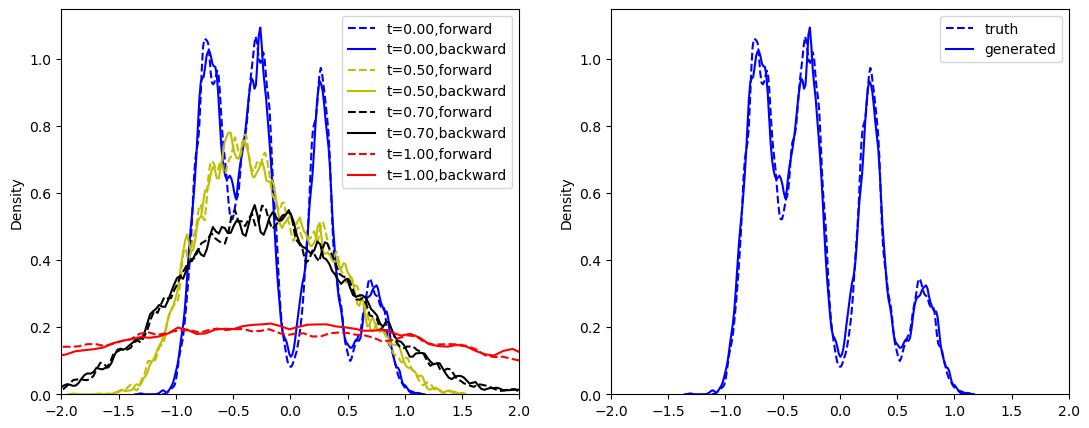

In [70]:
fig,ax = plt.subplots(1,2, figsize=(13, 5))

i=0
for idx in index_list:
    t = idx * T / 1000
    sns.kdeplot(XT[idx,:, 0], ax=ax[0], label='t=%.2f,forward' % t, bw_adjust=0.2, linestyle="--", c=color_list[i])
    sns.kdeplot(trajectory[1000-idx,:, 0], label='t=%.2f,backward' % t, ax=ax[0], bw_adjust=0.2, linestyle="-", c=color_list[i])
    i += 1
ax[0].set_xlim(-2, 2)
ax[0].legend()

sns.kdeplot(XT[0,:, 0], ax=ax[1], linestyle="--", bw_adjust=0.2, c='b', label='truth')
sns.kdeplot(trajectory[-1,:, 0], ax=ax[1], linestyle="-", bw_adjust=0.2, c='b', label='generated')
ax[1].set_xlim(-2, 2)
ax[1].legend()


torch.Size([100, 100])


Text(0.5, 1.0, 'score function')

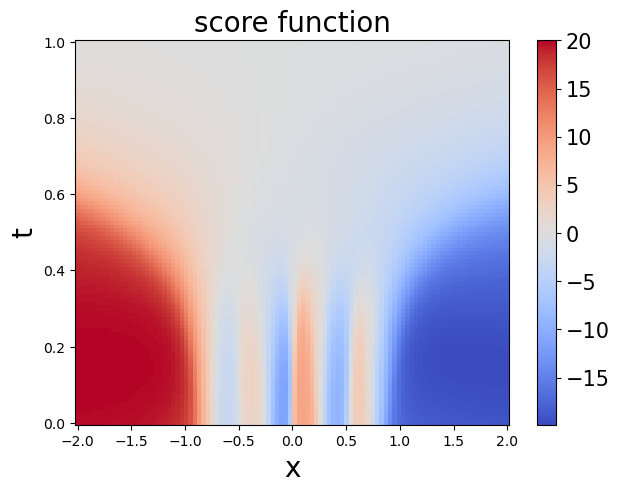

In [57]:
x = torch.linspace(-2, 2, 100)
t = torch.linspace(0, T, 100)
xv, tv = torch.meshgrid(x, t, indexing='ij')

score_xt = model(xv.reshape(-1, 1), tv.reshape(-1,1)).reshape(100,100)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)

im = ax.pcolormesh(xv.numpy(), tv.numpy(), score_xt.detach().numpy(), cmap='coolwarm',shading='auto')

cbar = fig.colorbar(im, ax=ax, shrink=1.0)
cbar.ax.tick_params(labelsize=15)

ax.set_xlabel(r'x',fontsize=20)
ax.set_ylabel(r't',fontsize=20)
ax.set_title('score function',fontsize=20)